# Задание **Ultra Lite**

Перепишите блоки занятия.

1. Моделируем нейросеть.

2. Задаем функцию потерь в соответствии с вознаграждением.

3. Генерация игрового эпизода с участием нейросети.

4. Обучаем сеть на серии игровых эпизодов.

Важно переписать эти блоки самостоятельно, не копируя. Копирование оставшихся блоков допускается.

# Импортирование библиотек

In [ ]:
!pip install gym==0.18.3
!pip install atari-py==0.2.5

     |████████████████████████████████| 1.6 MB 7.5 MB/s 
  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657534 sha256=be9f69899173bd953bdef23504836300c98621aea50417860b2d8b508b5661b6
  Stored in directory: /root/.cache/pip/wheels/1a/ec/6d/705d53925f481ab70fd48ec7728558745eeae14dfda3b49c99
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 2.8 MB 9.0 MB/s 
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [ ]:
import gym
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import matplotlib.pyplot as plt
import tensorflow as tf
import time

%matplotlib inline

In [ ]:
#Отключаем функционал из tf2.0, что бы код был совместим с современным тензорфлоуом
tf.compat.v1.disable_eager_execution()

# Перед нейросетью для понимания процесса

In [ ]:
env = gym.make('Pong-v0')
observation = env.reset()
observation.shape

(210, 160, 3)

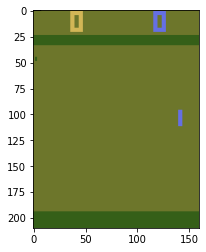

In [ ]:
plt.imshow(observation)
plt.show()

Кадр:  0
reward:  0.0
done:  False
info:  {'ale.lives': 0}


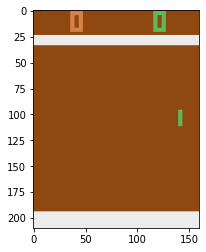

Кадр:  1
reward:  0.0
done:  False
info:  {'ale.lives': 0}


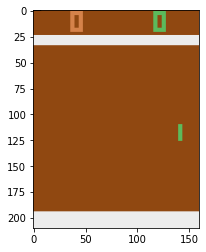

Кадр:  2
reward:  0.0
done:  False
info:  {'ale.lives': 0}


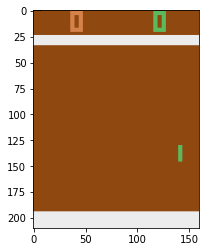

Кадр:  3
reward:  0.0
done:  False
info:  {'ale.lives': 0}


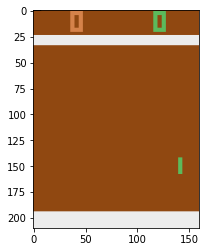

Кадр:  4
reward:  0.0
done:  False
info:  {'ale.lives': 0}


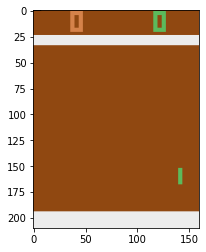

Кадр:  5
reward:  0.0
done:  False
info:  {'ale.lives': 0}


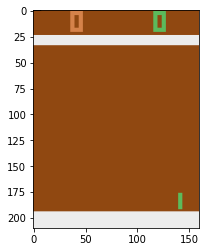

Кадр:  6
reward:  0.0
done:  False
info:  {'ale.lives': 0}


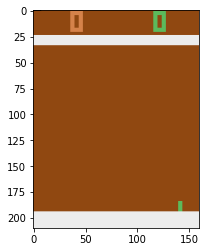

Кадр:  7
reward:  0.0
done:  False
info:  {'ale.lives': 0}


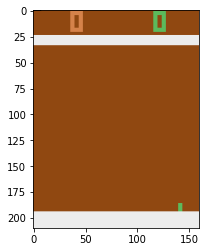

Кадр:  8
reward:  0.0
done:  False
info:  {'ale.lives': 0}


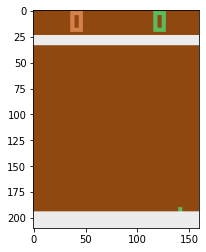

Кадр:  9
reward:  0.0
done:  False
info:  {'ale.lives': 0}


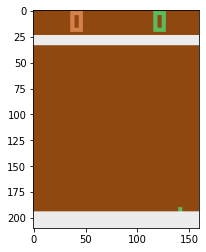

Кадр:  10
reward:  0.0
done:  False
info:  {'ale.lives': 0}


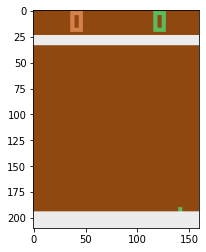

Кадр:  11
reward:  0.0
done:  False
info:  {'ale.lives': 0}


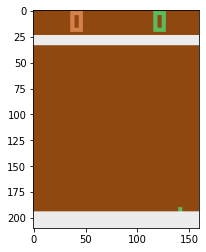

Кадр:  12
reward:  0.0
done:  False
info:  {'ale.lives': 0}


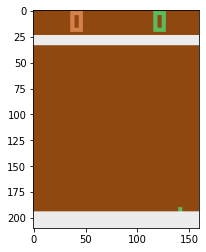

Кадр:  13
reward:  0.0
done:  False
info:  {'ale.lives': 0}


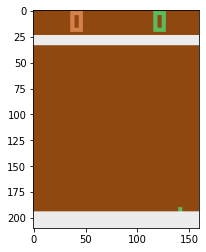

Кадр:  14
reward:  0.0
done:  False
info:  {'ale.lives': 0}


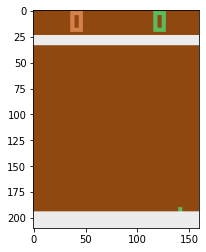

Кадр:  15
reward:  0.0
done:  False
info:  {'ale.lives': 0}


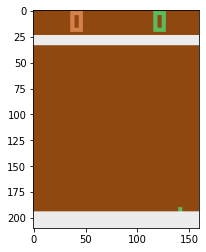

Кадр:  16
reward:  0.0
done:  False
info:  {'ale.lives': 0}


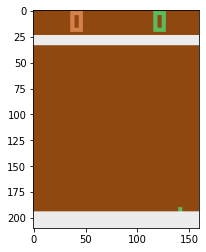

Кадр:  17
reward:  0.0
done:  False
info:  {'ale.lives': 0}


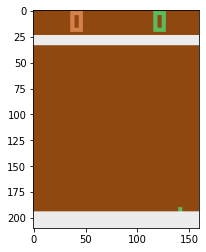

Кадр:  18
reward:  0.0
done:  False
info:  {'ale.lives': 0}


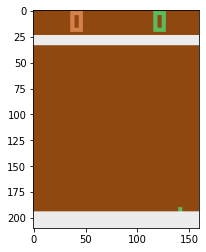

Кадр:  19
reward:  0.0
done:  False
info:  {'ale.lives': 0}


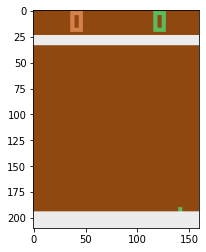

Кадр:  20
reward:  0.0
done:  False
info:  {'ale.lives': 0}


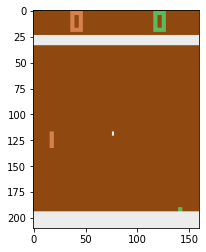

Кадр:  21
reward:  0.0
done:  False
info:  {'ale.lives': 0}


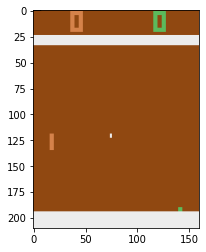

Кадр:  22
reward:  0.0
done:  False
info:  {'ale.lives': 0}


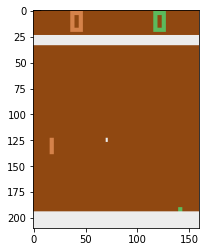

Кадр:  23
reward:  0.0
done:  False
info:  {'ale.lives': 0}


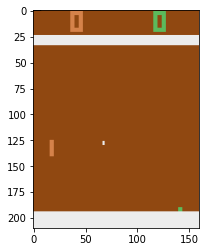

Кадр:  24
reward:  0.0
done:  False
info:  {'ale.lives': 0}


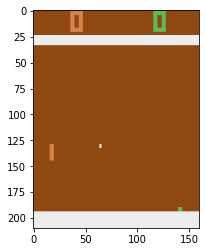

Кадр:  25
reward:  0.0
done:  False
info:  {'ale.lives': 0}


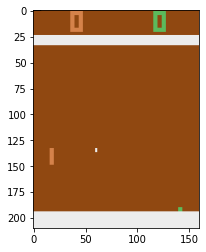

Кадр:  26
reward:  0.0
done:  False
info:  {'ale.lives': 0}


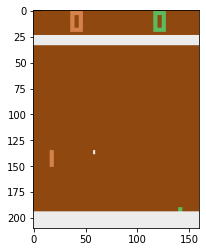

Кадр:  27
reward:  0.0
done:  False
info:  {'ale.lives': 0}


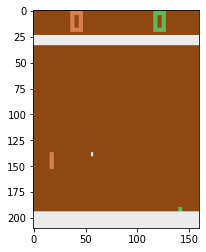

Кадр:  28
reward:  0.0
done:  False
info:  {'ale.lives': 0}


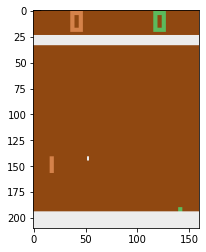

Кадр:  29
reward:  0.0
done:  False
info:  {'ale.lives': 0}


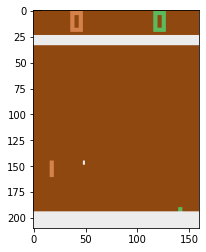

In [ ]:
# 30 Кадров
observation = env.reset()

for i in range(30):
  observation, reward, done, info = env.step(3)
  print("Кадр: ", i)
  print("reward: ", reward)
  print("done: ", done)
  print("info: ", info)
  plt.imshow(observation)
  plt.show()

In [ ]:
newObservation, reward, done, info = env.step(3)

# Игра

## Предобработка данных

In [ ]:
# Функция предобработки данных перед подачей в нейросеть
def preprocessFrames(newFrame, lastFrame):

  lFrame = lastFrame.astype(np.int32)
  lFrame[lFrame==144] = 0
  lFrame[lFrame==72] = 0

  nFrame = newFrame.astype(np.int32)
  nFrame[nFrame==144] = 0
  nFrame[nFrame==72] = 0

  deltaFrame = nFrame - lFrame

  deltaFrame = deltaFrame[35:195]
  deltaFrame = deltaFrame[::2, ::2, 0]

  maxValue = deltaFrame.max() if deltaFrame.max() > abs(deltaFrame.min()) else abs(deltaFrame.min())

  if maxValue !=0:
    deltaFrame = deltaFrame / maxValue
  
  return deltaFrame

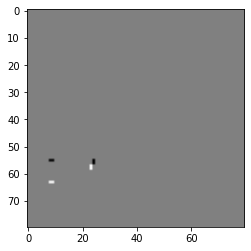

In [ ]:
plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray)
plt.show()

# Модель нейросети

In [ ]:
inputs = Input(shape=(80,80))
flattenLayer = Flatten()(inputs)
fullConnected = Dense(200, activation='relu', use_bias=False)(flattenLayer)
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)
policyNetworkModel = Model(inputs, sigmoidOutput)
policyNetworkModel.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 200)               1280000   
                                                                 
 dense_5 (Dense)             (None, 1)                 200       
                                                                 
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


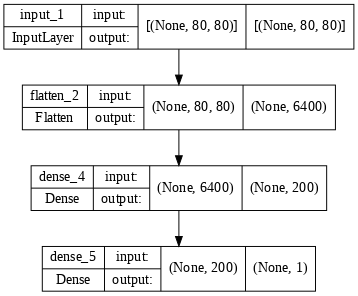

In [ ]:
plot_model(policyNetworkModel, show_shapes=True, dpi=70)

# Функция потерь в соответствии с вознаграждением

In [ ]:
# задаем награду за эпизод
episodeReward = Input(shape=(1,), name='episodeReward')

In [ ]:
# Самописная функция потерь
def rewardedLoss(episodReward):
  def loss(yTrue, yPred):
    tmpPred = Lambda(lambda x: keras.backend.clip(x, 0.05, 0.95))(yPred)
    tmpLoss = Lambda(lambda x: -yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    policyLoss = Multiply()([tmpLoss, episodeReward])
    return policyLoss
  return loss

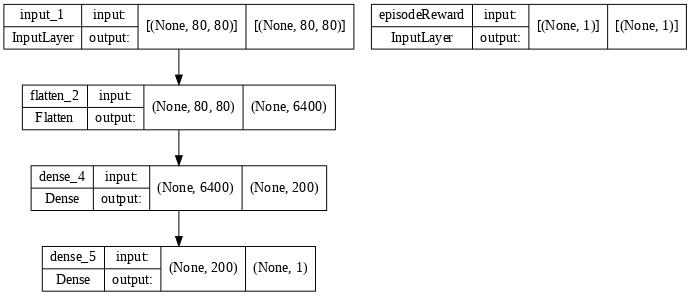

In [ ]:
# Создаем нейроную сеть для обучения
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)

plot_model(policyNetworkTrain, show_shapes=True, dpi=70)

In [ ]:
policyNetworkTrain.compile(optimizer=RMSprop(learning_rate=0.0001), loss=rewardedLoss(episodeReward))

## Генерация игрового эпизода с участием нейросети



In [ ]:
def generateEpisode(policyNetwork):
  statesList = []                # список состояний
  upDownActionList = []         # список движений
  rewardsList = []               # список наград
  networkOutputList = []        # вероятность 
  env = gym.make("Pong-v0")     # cоздание среды
  observation = env.reset()     # перезагрузка состояния среды
  newObservation = observation  # получение новое состояния
  done = False                  # завершение эпизода

  while done == False:
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation)
    statesList.append(processedNetworkInput)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0)

    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0]
    networkOutputList.append(upProbability)
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])

    if actualAction == 2: 
      upDownActionList.append(1.0)
    else:
      upDownActionList.append(0.0)
    
    observation = newObservation
    newObservation, reward, done, info = env.step(actualAction)

    rewardsList.append(reward)

    if done:
      break
  
  env.close()
  
  return statesList, upDownActionList, rewardsList, networkOutputList

In [ ]:
# Сгенерируем эпизод игры с необученной сетью

statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("----------------------")
print("Количество состояний в эпизоде = "+str(len(statesList)))
print("Форма состояния "+str(statesList[0].shape))
print("Количество наград за эпизод = "+str(len(rewardsList)))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


----------------------
Количество состояний в эпизоде = 1286
Форма состояния (80, 80)
Количество наград за эпизод = 1286


In [ ]:
# Взглянем на фрагмент списка вероятностей
print(networkOutputList[100:120])

[0.48502016, 0.50834346, 0.49978355, 0.5006177, 0.5031981, 0.4945431, 0.501199, 0.5284174, 0.49299762, 0.51107705, 0.503686, 0.49691656, 0.49529046, 0.50536627, 0.50194436, 0.5197144, 0.5046146, 0.49029532, 0.50615597, 0.4968344]


In [ ]:
# И так же на фактические действия
print(upDownActionList[100:120])

[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Выведем список наград
print(rewardsList[100:120])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Выигрышь в течение эпизода:
print("Количество выигранных очков  = " + str(len(list(filter(lambda r: r>0,rewardsList)))))
print("Количество проигранных очков = " + str(len(list(filter(lambda r: r<0,rewardsList)))))
print("Количество нулевых наград    = " + str(len(list(filter(lambda r: r==0,rewardsList)))))

Количество выигранных очков  = 1
Количество проигранных очков = 21
Количество нулевых наград    = 1264


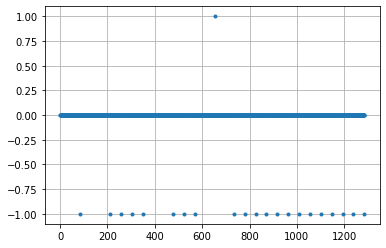

In [ ]:
# Выведем на графике полученные награды
plt.plot(rewardsList, '.')
ax=plt.gca()
ax.grid(True)

## Эффективно определяем вознаграждение



In [ ]:
# Функция, которая распределяет ненулевую награду для всех шагов в удачном/неудачном розыгрыше

def processRewards(rewardList):
  rewardDecay = 0.99
  tmpReward = 0
  rewardDecayed = np.zeros_like(rewardList, dtype=np.float32)

  for i in range(len(rewardList)-1, -1, -1):
    if rewardList[i] == 0:
      #print(f"{tmpReward}   *    {rewardDecay}   =   {tmpReward*rewardDecay}")
      tmpReward = tmpReward*rewardDecay
      rewardDecayed[i] = tmpReward
    else:
      tmpReward = rewardList[i]
      #print(tmpReward)
      rewardDecayed[i] = tmpReward
    
  rewardDecayed -= np.mean(rewardDecayed)
  rewardDecayed /= np.std(rewardDecayed)

  return rewardDecayed

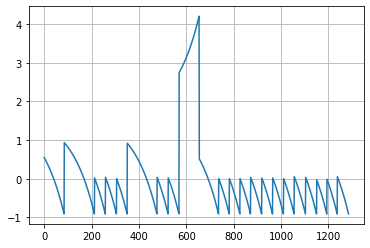

In [ ]:
plt.plot(processRewards(rewardsList), '-')
plt.grid()

## Пример игрового эпизода с последующей тренировкой сети




In [ ]:
# Сгенерируем новый игровой эпизод:
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("Количество состояний в эпизоде = "+str(len(statesList)))
print("Форма состояния "+str(statesList[0].shape))
print("Количество наград за эпизод = "+str(len(rewardsList)))

Количество состояний в эпизоде = 1477
Форма состояния (80, 80)
Количество наград за эпизод = 1477


In [ ]:
# Подготовим данные для тренировки  
x = np.array(statesList)
episodeReward = np.expand_dims(processRewards(rewardsList),1)
print(x.shape)
print(episodeReward.shape)

(1477, 80, 80)
(1477, 1)


In [ ]:
print(upDownActionList)

[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,

In [ ]:
yTmp = np.array(upDownActionList)
print(yTmp.shape)
yTrue = np.expand_dims(yTmp, 1)
print(yTrue.shape)

(1477,)
(1477, 1)


In [ ]:
print("Форма наград за эпизод =", episodeReward.shape)
print("Форма состояний среды =", x.shape)
print("Форма фактических движений =", yTrue.shape)

Форма наград за эпизод = (1477, 1)
Форма состояний среды = (1477, 80, 80)
Форма фактических движений = (1477, 1)


## Обучение сети

In [ ]:
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Train on 1477 samples
1477/1477 [==============================] - 1s 595us/sample - loss: -0.0010


In [ ]:
# Создадие серии игровых эпизодов и обучение
def generateEpisodeBatchesTraining(model, nBatches=10):
  env = gym.make('Pong-v0')
  batchStateList = []
  batchUpDownActionList = []
  batchRewardsList = []
  batchNetworkOutputList = []

  for i in range(nBatches):
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model)
    batchStateList.extend(statesList)
    batchNetworkOutputList.extend(networkOutputList)
    batchUpDownActionList.extend(upDownActionList)
    batchRewardsList.extend(rewardsList)

    episodeReward = np.expand_dims(processRewards(batchRewardsList), 1)
    x = np.array(batchStateList)
    yTmp = np.array(batchUpDownActionList)
    yTrue = np.expand_dims(yTmp, 1)

    history = policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue, epochs=10, verbose=0)

    batchLoss = history.history['loss'][-1]
    return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss


## Обучаем сеть на серии игровых эпизодов



In [ ]:
trainingTimes = 100

for training in range(trainingTimes):
  startTime = time.time()

  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))
  print("Время тренировки = " + str(round(endTime - startTime))+"сек")
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))
  rr=np.array(rewardsList)
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0])))
  print("")
  if training % 10 == 0:
    policyNetworkModel.save("policyNetworkModel.h5")
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")
    with open('rewardsModelSimple.txt','a') as recordingRewards:
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 9сек
Ошибка на тренировке = -0.04479
Выиграли очков = 0 Проиграли очков = 21

Тренировка = 2
Время тренировки = 11сек
Ошибка на тренировке = -0.05784
Выиграли очков = 0 Проиграли очков = 21

Тренировка = 3
Время тренировки = 9сек
Ошибка на тренировке = -0.05346
Выиграли очков = 0 Проиграли очков = 21

Тренировка = 4
Время тренировки = 11сек
Ошибка на тренировке = -0.08278
Выиграли очков = 0 Проиграли очков = 21

Тренировка = 5
Время тренировки = 11сек
Ошибка на тренировке = -0.06324
Выиграли очков = 1 Проиграли очков = 21

Тренировка = 6
Время тренировки = 11сек
Ошибка на тренировке = -0.1153
Выиграли очков = 0 Проиграли очков = 21

Тренировка = 7
Время тренировки = 10сек
Ошибка на тренировке = -0.0909
Выиграли очков = 0 Проиграли очков = 21

Тренировка = 8
Время тренировки = 15сек
Ошибка на тренировке = -0.08863
Выиграли очков = 0 Проиграли очков = 21

Тренировка = 9
Время тренировки = 11сек
Ошибка на тренировке = -0.05941
Выиграли очков = 1 Проиграли

## Сыграем эпизод обученной моделью и воспроизведем видео

In [ ]:
from IPython.display import clear_output
!apt update && apt install xvfb && pip install pyvirtualdisplay 
from gym.wrappers import Monitor
import glob
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
clear_output()
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# Функция записи и воспроизведения видео
def wrapEnv(env):
  env = Monitor(env, './video', force=True)
  return env

def showVideo():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = open(mp4, 'r+b').read()
    encoded = base64.b64encode(video) 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
  else:
    print("Could not find video")

In [ ]:
def playAndShowEpisode(policyNetwork):
    env = wrapEnv(gym.make('Pong-v0'))
    done = False
    observation = env.reset()
    newObservation = observation
    while done == False:
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation)
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0)
 
        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0]
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        env.render()
        observation = newObservation
        newObservation, reward, done, info = env.step(actualAction)
    env.close()
    showVideo()

# Запуск игровых эпизодах 

## Необученной моделью нейросети

In [ ]:
policyNetworkModel = load_model("/content/policyNetworkModel.h5")
playAndShowEpisode(policyNetworkModel)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## На 30 тренировках

In [ ]:
policyNetworkModel30 = load_model("/content/policyNetworkModel30.h5")
playAndShowEpisode(policyNetworkModel30)  

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## На 60 тренировках

In [ ]:
policyNetworkModel60 = load_model("/content/policyNetworkModel60.h5")
playAndShowEpisode(policyNetworkModel60)  

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## На 90 тренировках

In [ ]:
policyNetworkModel90 = load_model("/content/policyNetworkModel90.h5")
playAndShowEpisode(policyNetworkModel90)  

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
